In [1]:
import pandas as pd
import glob
import numpy as np

from urllib.request import urlretrieve
import os

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import pos_tag
import spacy

import ast
import matplotlib.pyplot as plt

from collections import Counter
import re

## Generate excerpts

In [ ]:
with open('./s2orc_full_text_nlp_ml.txt') as f:
    lines = f.read().splitlines()

In [ ]:
# from urllib.request import urlretrieve
# import gzip, shutil

# for fname in lines:
#     if not fname.startswith('https:/'):
#         fname = 'https://ai2-s2-research-public.s3-us-west-2.amazonaws.com/lucas/s2orc' + fname.split('s2orc')[1]
        
#     path, _ = urlretrieve(fname, './raw-data/' + fname.split('/')[-1])

#     with gzip.open(path, 'r') as f_in, open('.'.join(path.split('.')[:-1]).replace('raw-data', 'processed-data'), 'wb') as f_out:
#         shutil.copyfileobj(f_in, f_out)

In [ ]:
path = "raw-data"
does_exist = os.path.exists(path)
if not does_exist:
    os.makedirs(path)

    for fname in lines:
        if not fname.startswith('https:/'):
            fname = 'https://ai2-s2-research-public.s3-us-west-2.amazonaws.com/lucas/s2orc' + fname.split('s2orc')[1]

        path, _ = urlretrieve(fname, './raw-data/' + fname.split('/')[-1])

        pd.read_parquet(path)
        print(path)

In [ ]:
def process_text(text):
    wnpos = lambda e: ('a' if e[0].lower() == 'j' else e[0].lower()) if e[0].lower() in ['n', 'r', 'v'] else 'n'
    wnl = WordNetLemmatizer()

    tokens = word_tokenize(text)
    tokens_pos = pos_tag(tokens)
    lemmas = []
    for t, pos in tokens_pos:
        new_pos = wnpos(pos)
        lemmas.append(wnl.lemmatize(t, pos=new_pos))
    return lemmas

In [ ]:
nltk.download("wordnet")
nltk.download("omw-1.4")
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

search_terms = ['democra']
exclude_term = 'democrats'

matches = list()
num_nonreadable = 0

for filepath in glob.iglob('raw-data/*'):
    df = pd.read_parquet(filepath)
    
    for index, row in df.iterrows():
        for target in [row['metadata']['title'], row['metadata']['abstract'], row['content']['grobid']['contents']]:
            if target:
                target_sents = nltk.tokenize.sent_tokenize(target)
            else:
                num_nonreadable += 1
                continue
            
            for s in search_terms:
                matches.extend([(row['id'], m) for m in target_sents if s in m.lower() and exclude_term not in m.lower()])

In [ ]:
num_nonreadable

In [ ]:
matches_df = pd.DataFrame(matches, columns=['Corpus ID', 'Excerpt'])

In [ ]:
matches_df.sample(frac=1).to_csv('excerpts.csv')

In [ ]:
matches_df

In [10]:
print(len(pd.read_csv('excerpts.csv')))

3411


In [9]:
print(len(set(pd.read_csv('excerpts.csv')['Corpus ID'])))

1537


## Filter excerpts

In [11]:
excerpts_df = pd.read_csv('excerpts.csv')

In [12]:
with open('exclusion-terms.txt') as f:
    exclusion_terms = f.readlines()

fmt_exclusion_terms = []
for l in exclusion_terms:
    if l[0] == '-':
        l = l.strip()[2:].lower()
    elif l[0] == '+':
        l = l.strip()[2:]
    fmt_exclusion_terms.append(l)

In [13]:
keep = []
dems_and_reps = []

for index, row in excerpts_df.iterrows():
    fmt_excerpt = row["Excerpt"].lower()
    for target_match in re.finditer("democra", fmt_excerpt):
        flag = False
        for term in fmt_exclusion_terms:
            if term.lower() != term:
                term_matches = re.finditer(r'\b' + term + r'\b', row["Excerpt"])
            else:
                term_matches = re.finditer(r'\b' + term + r'\b', fmt_excerpt)
            for term_match in term_matches:
                if target_match.start() >= term_match.start() and target_match.end() <= term_match.end():
                    flag = True
                    break
        if not flag:
            if ('democratic' in fmt_excerpt or 'democrat' in fmt_excerpt) and 'republican' in fmt_excerpt:
                dems_and_reps.append(fmt_excerpt)
            keep.append(row)
            break

In [14]:
len(dems_and_reps)

28

In [15]:
for excerpt in dems_and_reps:
    print(excerpt)
    print()
    print('======')
    print()

one interesting observation is that when the model is tested with the or data, the drop is even sharper as or tends to be a democratic state; while wi and in are often republican states.


our algorithm was configured to use a rank-4 approximation of the input data.topic 1 

topic 2 
topic 3 
topic 4 
topic 5 
topic 6 
topic 7 
topic 8 

1: 

tpower 

percent 
zzz bush 
team 
school 
com 
zzz enron 
law 
palestinian 

2: company 

zzz al gore 
game 
student 
women 
firm 
drug 
zzz israel 

3: million 

zzz george bush 
season 
program 
book 
deal 
court 
zzz israeli 

4: companies 

campaign 
player 
children 
web 
financial 
case 
zzz yasser arafat 

5: market 

right 
play 
show 
american 
zzz arthur andersen federal 
peace 

6: stock 

group 
games 
public 
information 
chief 
patient 
israelis 

7: money 

political 
point 
need 
look 
executive 
system 
israeli 

8: business 

zzz united states run 
part 
site 
analyst 
decision 
military 

9: government zzz u s 

coach 
family 
z

In [16]:
filtered_excerpts = pd.DataFrame(keep).drop(columns=['Unnamed: 0'])

In [17]:
len(filtered_excerpts)

2273

In [ ]:
filtered_excerpts.to_csv('filtered-excerpts.csv')

## Over Time

In [2]:
prefiltered_papers_df = pd.read_csv('annotated-excerpts-with-themes.csv')

In [3]:
filtered_papers_df = prefiltered_papers_df[prefiltered_papers_df['1 = Relevant / 0 = Irrelevant'] == 1]
filtered_papers_df = filtered_papers_df[filtered_papers_df['1 = Reference'] != 1]

In [4]:
len(filtered_papers_df)

923

In [5]:
filtered_papers = set(filtered_papers_df['Corpus ID'])

In [6]:
len(filtered_papers)

507

In [7]:
all_years = []
filtered_rows = []

for filepath in glob.iglob('raw-data/*'):
    df = pd.read_parquet(filepath)
    
    for index, row in df.iterrows():
        if row['id'] in filtered_papers:
            filtered_rows.append(row)
            
        if row['metadata']['publication_date'] and row['metadata']['publication_date']['year']:
            all_years.append(row['metadata']['publication_date']['year'])

In [8]:
df = pd.DataFrame(filtered_rows)

In [9]:
filtered_years = []

for index, row in df.iterrows():
    if row['metadata']['publication_date'] and row['metadata']['publication_date']['year']:
        filtered_years.append(row['metadata']['publication_date']['year'])

In [10]:
import numpy as np
import matplotlib.pyplot as plt

filtered_uniq, filtered_counts = np.unique(filtered_years, return_counts=True)

In [11]:
denom = (filtered_uniq.reshape(-1, 1) == np.array(all_years).reshape(1, -1)).sum(axis=1)

In [12]:
filtered_uniq = np.append(filtered_uniq, [2024])

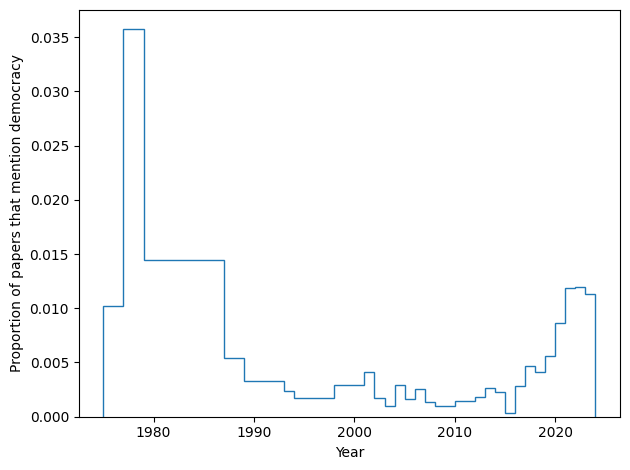

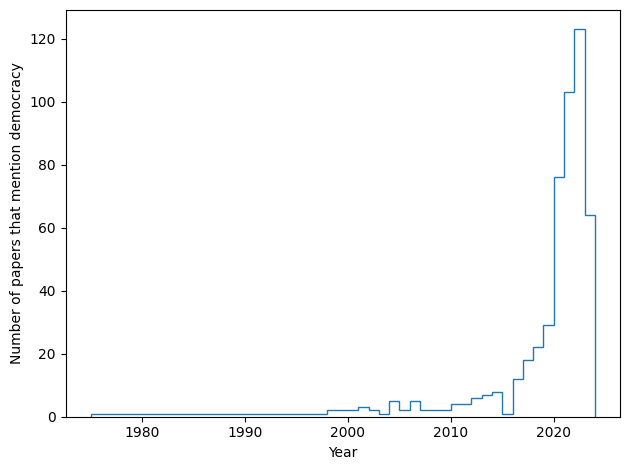

In [13]:
plt.stairs((filtered_counts / denom), filtered_uniq)
plt.xlabel("Year")
plt.ylabel("Proportion of papers that mention democracy")
plt.tight_layout()
plt.savefig('explore-papers-plots/prop-papers-over-time.png')
plt.show()

plt.stairs(filtered_counts, filtered_uniq)
plt.xlabel("Year")
plt.ylabel("Number of papers that mention democracy")
plt.tight_layout()
plt.savefig('explore-papers-plots/raw-num-over-time.png')
plt.show()

## Affiliations

In [14]:
# from s2aff import S2AFF
# from s2aff.ror import RORIndex
# from s2aff.model import NERPredictor, PairwiseRORLightGBMReranker

In [15]:
# # an example affiliation
# raw_affiliation = "Microsoft Research\nBangaloreIndia"

# # instantiate the ner model and the ror index. loading first time will take ~10-30s
# ner_predictor = NERPredictor(use_cuda=False)  # defaults to models in the data directory
# ror_index = RORIndex()  # ditto

In [16]:
# candidates, scores = ror_index.get_candidates_from_raw_affiliation("Argentina", ner_predictor)
# ror_index.ror_dict[candidates[0]]

In [17]:
exclude_terms = set([
    'germany',
    'department of linguistics',
    'uk',
    'school of computer science',
    'china',
    'usa',
    'computer science',
    'india',
    'italy',
    'berkeley',
    'united kingdom',
    'computer science department',
    'department of computer science and engineering',
    'department of computer science',
    'beijingchina',
    'denmark',
    'switzerland',
    'institute for natural language processing',
    'ims'
])

In [18]:
all_affils = []

for index, row in df.iterrows():
    if row['content']['grobid']['annotations']['author_affiliation']:
        affiliation_pos = ast.literal_eval(row['content']['grobid']['annotations']['author_affiliation'])
        
        paper_affils = []
        for pos in affiliation_pos:
            start, end = pos['start'], pos['end']
            if type(start) != int:
                start = int(start)
            if type(end) != int:
                end = int(end)

            raw_affils = row['content']['grobid']['contents'][start:end].strip().lower().split('\n')
            paper_affils.extend(raw_affils)
            
        all_affils.extend(list(set([affil for affil in paper_affils if affil not in exclude_terms])))

In [19]:
# uniq_affils, counts_affils = np.unique(all_affils, return_counts=True)
# uniq_affils = uniq_affils[np.argsort(-counts_affils)]
# counts_affils = counts_affils[np.argsort(-counts_affils)]

In [20]:
# affils_map = {}

# for raw_affil in uniq_affils[:200]:
#     candidates, scores = ror_index.get_candidates_from_raw_affiliation(raw_affil, ner_predictor)
#     cand_info = ror_index.ror_dict[candidates[0]]
#     if "Education" in cand_info["types"] or "Company" in cand_info["types"] or "Nonprofit" in cand_info["types"]:
#         affils_map[raw_affil] = cand_info["name"]

In [21]:
# relabeled_affils = [affils_map[affil] for affil in all_affils if affil in affils_map]
# uniq_affils, counts_affils = np.unique(relabeled_affils, return_counts=True)

uniq_affils, counts_affils = np.unique(all_affils, return_counts=True)

k = 10
topk_affils = np.argsort(-counts_affils)[:k]
list(zip(uniq_affils[topk_affils], counts_affils[topk_affils]))

[('stanford university', 17),
 ('carnegie mellon university', 12),
 ('university of stuttgart', 11),
 ('university of cambridge', 8),
 ('columbia university', 7),
 ('university of copenhagen', 7),
 ('cnrs', 6),
 ('national taiwan university', 6),
 ('technical university of darmstadt', 6),
 ('university of toronto', 6)]

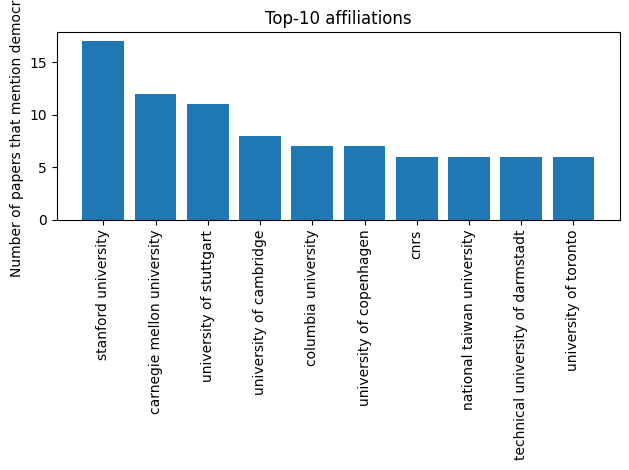

In [22]:
plt.bar(uniq_affils[topk_affils], counts_affils[topk_affils])
for tick in plt.gca().get_xticklabels():
    tick.set_rotation(90)
plt.ylabel('Number of papers that mention democracy')
plt.title('Top-10 affiliations')
plt.tight_layout()
plt.savefig('explore-papers-plots/affiliations.png')
plt.show()

## Authors

In [23]:
all_authors = []

for index, row in df.iterrows():
    if row['metadata']['authors']:
        authors = ast.literal_eval(row['metadata']['authors'])
        
        for author in authors:
            all_authors.append(' '.join([author['first'].strip().lower()] + [t.strip().lower() for t in author['middle']] + [author['last'].strip().lower()]))

In [24]:
uniq_authors, counts_authors = np.unique(all_authors, return_counts=True)

In [25]:
k = 10
topk_authors = np.argsort(-counts_authors)[:k]
list(zip(uniq_authors[topk_authors], counts_authors[topk_authors]))

[('gabriella lapesa', 7),
 ('preslav nakov', 7),
 ('yulia tsvetkov', 5),
 ('iryna gurevych', 5),
 ('tommaso caselli', 5),
 ('andre blessing', 4),
 ('walter daelemans', 4),
 ('dirk hovy', 4),
 ('sebastian padó', 4),
 ('neele falk', 4)]

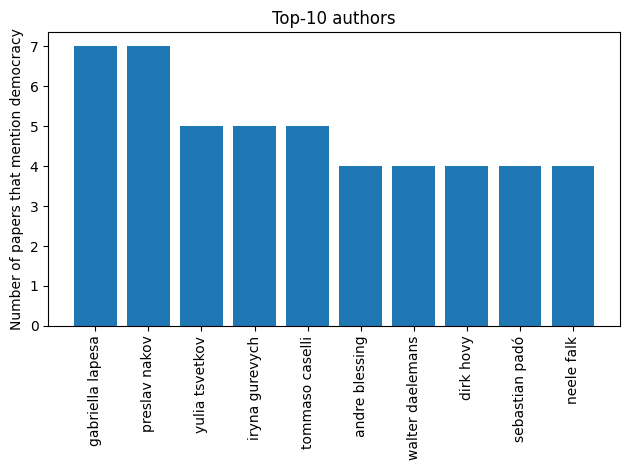

In [26]:
plt.bar(uniq_authors[topk_authors], counts_authors[topk_authors])
for tick in plt.gca().get_xticklabels():
    tick.set_rotation(90)
plt.ylabel('Number of papers that mention democracy')
plt.title('Top-10 authors')
plt.tight_layout()
plt.savefig('explore-papers-plots/authors.png')
plt.show()

## Paper structure

In [27]:
prefiltered_papers_df = pd.read_csv('annotated-excerpts-with-themes.csv')
filtered_papers_df = prefiltered_papers_df[prefiltered_papers_df['1 = Relevant / 0 = Irrelevant'] == 1]
excerpts_df = filtered_papers_df[filtered_papers_df['1 = Reference'] != 1]
excerpts_map = {}

for index, row in excerpts_df.iterrows():
    if row['Corpus ID'] not in excerpts_map:
        excerpts_map[row['Corpus ID']] = []
    excerpts_map[row['Corpus ID']].append(row['Excerpt'])

In [28]:
all_sections = []

for index, row in df.iterrows():
    for excerpt in excerpts_map[row['id']]:
        
        excerpt_idx = row['metadata']['title'].find(excerpt)
        if excerpt_idx != -1:
            all_sections.append("title")
            continue

        if row['metadata']['abstract']:
            excerpt_idx = row['metadata']['abstract'].find(excerpt)
            if excerpt_idx != -1:
                all_sections.append("abstract")
                continue
        
        excerpt_idx = row['content']['grobid']['contents'].find(excerpt)

        figure_flag = False
        if row['content']['grobid']['annotations']['figure']:
            figures = ast.literal_eval(row['content']['grobid']['annotations']['figure'])
            figure_flag = False
            for figure in figures:
                start, end = figure['start'], figure['end']
                if type(start) != int:
                    start = int(start)
                if type(end) != int:
                    end = int(end)
                    
                if start <= excerpt_idx and end >= excerpt_idx + len(excerpt):
                    all_sections.append("figure")
                    figure_flag = True
                    break
        if figure_flag:
            continue

        table_flag = False
        if row['content']['grobid']['annotations']['table']:
            tables = ast.literal_eval(row['content']['grobid']['annotations']['table'])
            table_flag = False
            for table in tables:
                start, end = table['start'], table['end']
                if type(start) != int:
                    start = int(start)
                if type(end) != int:
                    end = int(end)

                if start <= excerpt_idx and end >= excerpt_idx + len(excerpt):
                    all_sections.append("table")
                    table_flag = True
                    break
        if table_flag:
            continue

        if row['content']['grobid']['annotations']['section_header']:
            section_headers = ast.literal_eval(row['content']['grobid']['annotations']['section_header'])

            prev_header = "abstract"
            for header in section_headers:
                start, end = header['start'], header['end']
                if type(start) != int:
                    start = int(start)
                if type(end) != int:
                    end = int(end)

                curr_header = row['content']['grobid']['contents'][start:end].lower()
                if "table " in curr_header:
                    curr_header = "table"
                elif "figure " in curr_header:
                    curr_header = "figure"
                elif "conclusions" == curr_header or "discussions" == curr_header or "related works" == curr_header or "related work and discussions" == curr_header:
                    curr_header = curr_header[:-1]
                elif len(curr_header) > 2 and curr_header[1] == " " and curr_header[0] != "a":
                    curr_header = curr_header[2:]

                if curr_header in ['related work', 'related work and discussion']:
                    curr_header = 'related work'
                elif curr_header in ['ethics statement', 'ethical considerations']:
                    curr_header = 'ethics'
                elif curr_header in ['data', 'data and tasks']:
                    curr_header = 'data'
                elif curr_header in ['conclusion', 'conclusion and future work']:
                    curr_header = 'conclusion'
                
                if excerpt_idx < start:
                    all_sections.append(prev_header)
                    break

                prev_header = curr_header

In [29]:
uniq_sections, counts_sections = np.unique(all_sections, return_counts=True)

In [30]:
k = 10
topk_sections = np.argsort(-counts_sections)[:k]
list(zip(uniq_sections[topk_sections], counts_sections[topk_sections]))

[('abstract', 259),
 ('introduction', 203),
 ('conclusion', 40),
 ('ethics', 24),
 ('related work', 19),
 ('figure', 15),
 ('broader impact', 13),
 ('recent diversity efforts', 7),
 ('details of implementation', 6),
 ('discussion', 6)]

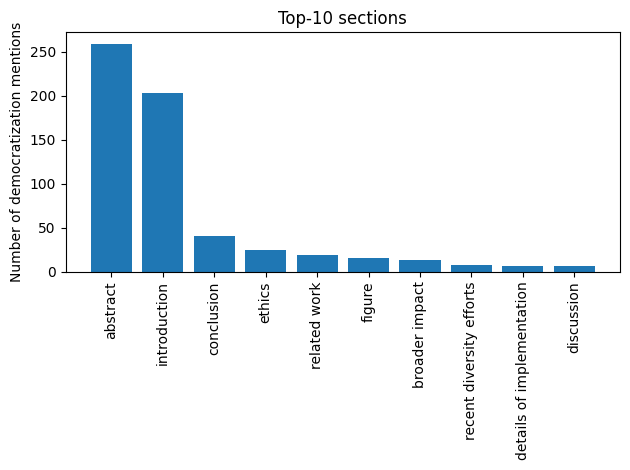

In [31]:
plt.bar(uniq_sections[topk_sections], counts_sections[topk_sections])
for tick in plt.gca().get_xticklabels():
    tick.set_rotation(90)
plt.ylabel('Number of democratization mentions')
plt.title('Top-10 sections')
plt.tight_layout()
plt.savefig('explore-papers-plots/sections.png')
plt.show()

In [32]:
np.sum(counts_sections[topk_sections][:3]) / np.sum(counts_sections[topk_sections])

0.847972972972973

In [33]:
all_freqs = [len(v) for k, v in excerpts_map.items()]

uniq_freqs, counts_freqs = np.unique(all_freqs, return_counts=True)
topk_freqs = np.argsort(-counts_freqs)[:k]
list(zip(uniq_freqs[topk_freqs], counts_freqs[topk_freqs]))

[(1, 385),
 (2, 66),
 (3, 27),
 (4, 11),
 (5, 6),
 (6, 2),
 (7, 2),
 (8, 1),
 (9, 1),
 (16, 1)]

In [34]:
print(np.array(counts_freqs) / sum(counts_freqs) * 100)

[75.93688363 13.01775148  5.32544379  2.16962525  1.18343195  0.39447732
  0.39447732  0.19723866  0.19723866  0.19723866  0.19723866  0.19723866
  0.19723866  0.19723866  0.19723866]


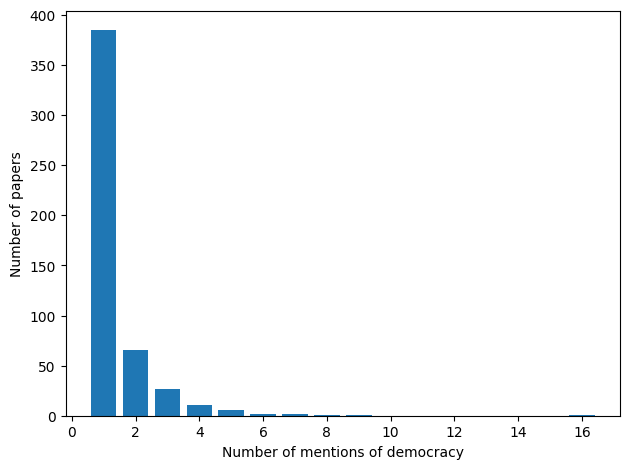

In [35]:
plt.bar(uniq_freqs[topk_freqs], counts_freqs[topk_freqs])
plt.ylabel('Number of papers')
plt.xlabel('Number of mentions of democracy')
plt.tight_layout()
plt.savefig('explore-papers-plots/mentions-per-paper.png')
plt.show()

## Acknowledgments

In [36]:
nlp = spacy.load("en_core_web_lg")
print(nlp.get_pipe("ner").labels)

('CARDINAL', 'DATE', 'EVENT', 'FAC', 'GPE', 'LANGUAGE', 'LAW', 'LOC', 'MONEY', 'NORP', 'ORDINAL', 'ORG', 'PERCENT', 'PERSON', 'PRODUCT', 'QUANTITY', 'TIME', 'WORK_OF_ART')


In [37]:
def add_children(tokens):
    for i, t in enumerate(tokens):
        tokens[i]['children'] = set()
    for i, t in enumerate(tokens):
        if t['dep'] != 'ROOT':
            head = t['head']
            tokens[head]['children'].add(t['id'])

def flood_children(tokens, i):
    seen = set()
    s = [i]
    while s != []:
        id = s.pop()
        seen.add(id)
        for ch in tokens[id]['children']:
            s.append(ch)
    return seen

def all_children(tok):
    seen = set()
    s = [tok]
    while s != []:
        t = s.pop()
        seen.add(t)
        for ch in t.children:
            s.append(ch)
    return sorted([t.i for t in seen])

def make_ignore_set(parse):
    ignore = set()

    # sentences about corresponding author
    for s in parse.sents:
        if 'corresponding author' in s.text or 'contact author' in s.text:
            for id in range(s.start, s.end):
                ignore.add(id)
    
    tokens = parse.to_json()['tokens']
    add_children(tokens)
    
    # passive subject of "is supported by"
    support_verbs = set(['support', 'fund'])
    for t in tokens:
        if t['lemma'] in support_verbs:
            for cid in t['children']:
                child = tokens[cid]
                if child['dep'] == 'nsubjpass':
                    for id in flood_children(tokens, child['id']):
                        ignore.add(id)
    
    return ignore

In [38]:
all_acks = []
num_paper_with_acks = 0

for index, row in df.iterrows():
    if row['content']['grobid']['annotations']['section_header']:
        section_headers = ast.literal_eval(row['content']['grobid']['annotations']['section_header'])

        prev_end = None
        for header in section_headers:
            start, end = header['start'], header['end']
            if type(start) != int:
                start = int(start)
            if type(end) != int:
                end = int(end)

            if prev_end is not None:
                ack = row['content']['grobid']['contents'][prev_end:start].replace("-\n", "").replace("\n", "").strip()
                all_acks.append(ack)
                break

            curr_header = row['content']['grobid']['contents'][start:end]
            if "Acknowledg" in curr_header or "Funding" in curr_header or "Disclosure" in curr_header:
                num_paper_with_acks += 1
                prev_end = end

In [39]:
parses = [nlp(ack) for ack in all_acks]
print([[(e, e.label_) for e in p.ents] for p in parses])

[[(NVIDIA, 'ORG'), (Huan Ling, 'PERSON'), (Seung Wook Kim, 'PERSON'), (University of Toronto, 'ORG'), (the Vector Institute, 'ORG')], [(Cortney Napoles, 'PERSON'), (Leonardo Neves, 'PERSON'), (Viktor Zamaruiev, 'PERSON'), (Max Gubin, 'PERSON'), (Ukraine, 'GPE'), (Russian, 'NORP'), (Ukraine, 'GPE'), (Ukraine, 'GPE'), (DeTexD., 'ORG')], [], [(Anjalie Field, 'ORG'), (Lucille Njoo, 'PERSON'), (Vidhisha Balachandran, 'PERSON'), (Sebastin Santy, 'ORG'), (Sneha Kudugunta, 'GPE'), (Melanie Sclar, 'PERSON'), (Tsvetshop, 'PERSON'), (the UW NLP Group, 'ORG'), (DARPA, 'ORG'), (HR001120C0124, 'PERSON'), (NSF, 'ORG'), (IIS2142739, 'ORG'), (the Alfred P. Sloan Foundation Fellowship, 'ORG'), (NSF, 'ORG'), (the United States Government, 'ORG'), (A Probing Language Models, 'LAW')], [(NSF, 'ORG'), (1937143, 'CARDINAL'), (Duke University, 'ORG'), (the Duke Tech & Check Cooperative, 'ORG'), (the Knight Foundation, 'ORG'), (Facebook, 'ORG')], [(Nicolas Devatine's, 'PERSON'), (ANR, 'ORG'), (the AI Interdisci

In [40]:
num_paper_with_acks

54

In [41]:
abbreviations = {
    "National Science Foundation": "NSF",
    "Defense Advanced Research Projects Agency": "DARPA",
    "The U.S. Government": "U.S. Government",
    "European Research Council": "ERC",
    "Intelligence Advanced Research Projects Activity": "IARPA",
    "Natural Science Foundation of China": "NSFC",
    "National Natural Science Foundation of China": "NSFC",
    "National Key Research and Development Program of China": "NKP",
    "National Key R&D Program of China": "NKP",
    "Army Research Office": "ARO",
    "Office of Naval Research": "ONR",
    "Air Force Research Laboratory": "AFRL",
    "Engineering and Physical Sciences Research Council": "EPSRC",
    "European Union": "EU",
    "Deutsche Forschungsgemeinschaft": "DFG",
    "German Research Foundation": "DFG",
    # "German Ministry of Education and Research": "BMBF",
    # "Federal Ministry of Education and Research": "BMBF",
    "Ministry of Education": "BMBF",
    "German Federal Ministry of Education and Research": "BMBF",
    "Bundesministerium für Bildung und Forschung": "BMBF",
    "Nederlandse Organisatie voor Wetenschappelijk Onderzoek": "NWO",
    "Dutch Research Council": "NWO",
    "Agence Nationale De La Recherche": "ANR",
    "French National Research Agency": "ANR",
    "Engineering and Physical Sciences Research Council": "EPSRC",
    "Foundation for Science and Technology": "FCT",
    "Fundação para a Ciência e a Tecnologia": "FCT",
    "Institute for Development and Resources in Intensive Scientific Computing": "IDRIS"
}

exclude_set = set([
    "governmental",
    "nlp",
    "description et modélisation des chaînes de référence",
    "zhou",
    "alector"
])

abbreviations = {k.lower() : v.lower() for k, v in abbreviations.items()}

companies = set(["google", "facebook", "meta", "microsoft", "ebay", "amazon", "adobe", "apple", "nvidia", "bloomberg", "salesforce", "ericsson", "intel", "futurewei", "vmware"])
for c in companies:
    abbreviations[c] = c

def abbreviate(name):
    return abbreviations.get(name, name)

def abbreviate(name):
    return abbreviations.get(name, name)

def count_acks(data, parses, ent_type):
    count = Counter()
    sorted_abbrs = sorted(abbreviations, key=lambda x: -len(x))

    for text, p in zip(data, parses):
        ignore = make_ignore_set(p)
        
        text = text.lower().replace("'s", "")
        seen = set()

        if ent_type == "ORG":
            for name in sorted_abbrs:
                text = text.replace(name, abbreviations[name])
    
            for abbr in abbreviations.values():
                myregex = r"\W" + re.escape(abbr) + r"\W"
                if re.findall(myregex, text):
                    seen.add(abbr)
                    count[abbr] += 1

        for e in p.ents:
            if any(i in ignore for i in range(e.start, e.end)):
                continue
                
            if e.label_ == ent_type:
                abbr = re.sub(r"^[Tt]he ", "", e.text).lower().replace("'s", "")
                abbr = abbreviate(abbr)

                if abbr not in seen and abbr not in exclude_set:
                    seen.add(abbr)
                    count[abbr] += 1
    return count

[('nsf', 5), ('anr', 4), ('dfg', 4), ('nwo', 4), ('bmbf', 3), ('erc', 3), ('vector institute', 2), ('fct', 2), ('eu', 2), ('epsrc', 2), ('nvidia', 1), ('university of toronto', 1), ('detexd.', 1), ('darpa', 1), ('anjalie field', 1), ('sebastin santy', 1), ('uw nlp group', 1), ('iis2142739', 1), ('alfred p. sloan foundation fellowship', 1), ('united states government', 1)]


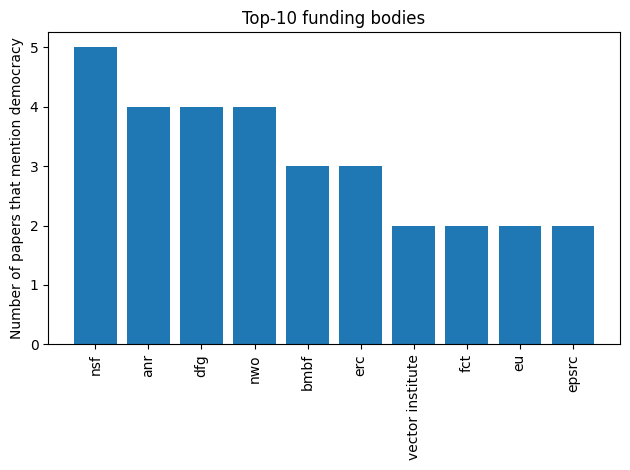

In [42]:
count_orgs = count_acks(all_acks, parses, ent_type="ORG")
print(count_orgs.most_common(20))

k = 10
acks_plot_data = list(zip(*count_orgs.most_common(k)))
plt.bar(list(acks_plot_data[0]), list(acks_plot_data[1]))
for tick in plt.gca().get_xticklabels():
    tick.set_rotation(90)
plt.ylabel('Number of papers that mention democracy')
plt.title('Top-10 funding bodies')
plt.tight_layout()
plt.savefig('explore-papers-plots/funding-bodies.png')
plt.show()

[('huan ling', 1), ('seung wook kim', 1), ('cortney napoles', 1), ('leonardo neves', 1), ('viktor zamaruiev', 1), ('max gubin', 1), ('lucille njoo', 1), ('vidhisha balachandran', 1), ('melanie sclar', 1), ('tsvetshop', 1)]


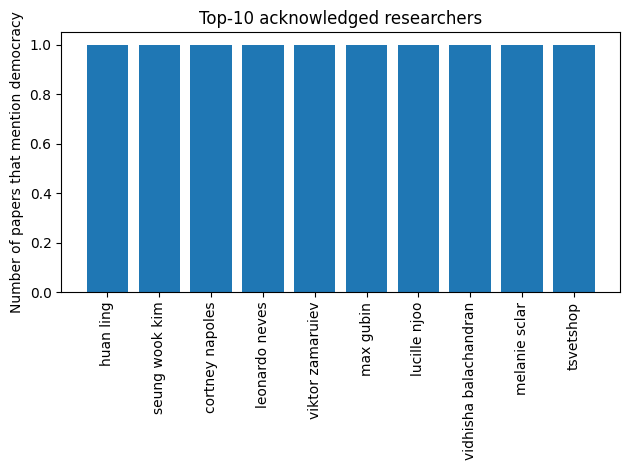

In [43]:
count_persons = count_acks(all_acks, parses, ent_type="PERSON")
print(count_persons.most_common(10))

acks_plot_data = list(zip(*count_persons.most_common(k)))
plt.bar(list(acks_plot_data[0]), list(acks_plot_data[1]))
for tick in plt.gca().get_xticklabels():
    tick.set_rotation(90)
plt.ylabel('Number of papers that mention democracy')
plt.title('Top-10 acknowledged researchers')
plt.tight_layout()
plt.show()